In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import dataiku
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataiku import pandasutils as pdu
import pandas as pd
from shapely.geometry import Point, MultiPoint, MultiPolygon
from shapely.ops import nearest_points
import geopandas as gpd
from shapely import wkt
import datetime as dt
import json
import branca.colormap
from collections import defaultdict
import webbrowser
import seaborn as sns

In [4]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("Zeeweg_Night_Day")
zeeweg = mydataset.get_dataframe()

In [5]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("wegvakken_v")
wegvakken = mydataset.get_dataframe()

In [6]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("final_road_objects")
objects = mydataset.get_dataframe()

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (6,7,11,14,16,17,18,21,22,23,24,25,26,27,28,31,35,47,48,49,50,53,54,58,59,60,63,65,66,67,68,69,70,74,78,84,85,86,88,89,90,91,93,96,98,101,102,103,108,110,111,112,113,114,115,116,118,119,121,125,126,127,128,129,130,131,133,134,139,140,141,145,146,147,148,149,150,151) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
#check unique ID's
objects['ID'].unique()

array([15, 16, 17, 18, 19, 23, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 36,
       35, 32, 33, 38, 40, 39, 41, 44, 46, 54, 47, 48, 52, 51, 50, 53, 60,
       57, 72, 58, 62, 64, 65, 66, 59, 74, 67, 68, 55, 70, 69, 75, 71, 76,
       77, 78, 79, 81, 86, 84, 82, 83, 87, 88, 89, 93, 92, 95, 96, 91, 90,
       94, 97])

In [8]:
#change time to normal format
def time(tijd):
    if tijd == 0:
        return 0
    s = tijd/ 1000.0
    dFormat = "%Y-%m-%d %H:%M:%S.%f"
    return dt.datetime.fromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S.%f')

In [9]:
#fill na
objects['attributes.objectbegintijd'] = objects['attributes.objectbegintijd'].fillna(0)

In [10]:
#create groups used by province
def group_index(index):

    if index < 26:
        return 'OVL en VRI'
    elif index == 46:
        return index
    elif index > 26 and index < 42:
        return 'Meubilair'
    elif index > 42 and index < 63 and index != 46:
        return 'Landschap & milieu'
    elif index > 63 and index < 73:
        return 'Kunstwerken'
    elif index > 73 and index < 80:
        return 'Kabels en leidingen'
    elif index > 80 and index < 85:
        return 'Openbaar vervoer'
    elif index > 85 and index < 98:
        return 'vaarwegen'
    else:
        return index

In [11]:
#create handmade groups
def group_index(index):
    bord = [38, 86, 30, 32, 36]
    # bord = [0.022, -0.031, 0.17, 0.53]
    # licht = [0.092, 0.55, -0.32]
    #vegetatie = [- , -0.34, - ]
    licht = [15, 16, 17]
    kast = [18, 19, 20, 28]
    sensor = [23, 24]
    spoor = [33, 34]
    vegetatie_object = [45, 46, 47]
    terreindeel = [48, 50, 57, 58, 59, 60, 62]
    kunstwerk = [64, 69, 71, 72]
    kabel = [75, 79]
    buis = [74, 77, 78]
    water_inrichting_element = [87, 88]

    if index in bord:
        return 'Bord'
    elif index in licht:
        return 'licht'
    elif index in kast:
        return 'kast'
    elif index in sensor:
        return 'sensor'
    elif index in spoor:
        return 'spoor'
    elif index in vegetatie_object:
        return 'vegetatie_object'
    elif index in terreindeel:
        return 'terreindeel'
    elif index in kunstwerk:
        return 'kunstwerk'
    elif index in kabel:
        return 'kabel'
    elif index in buis:
        return 'buis'
    elif index in water_inrichting_element:
        return 'water_inrichting_element'

In [12]:
#change ID to group number
objects['ID'] = objects['ID'].apply(group_index)

In [13]:
#change time to datetime
objects['attributes.objectbegintijd'] = objects['attributes.objectbegintijd'].apply(time)

In [14]:
#split solar pannels and pumps
objects[objects['ID'] == 27]['attributes.typespec'].unique
objects.loc[objects['attributes.typespec'] == 'Pomp', 'ID'] = '27_pomp'
objects.loc[objects['attributes.typespec'] == 'Zonnepaneel', 'ID'] = '27_Zonnepaneel'

In [15]:
#Check unique ID's
objects['ID'].unique()

array(['licht', 'kast', 'sensor', None, '27_pomp', '27_Zonnepaneel',
       'Bord', 'spoor', 'vegetatie_object', 'terreindeel', 'kunstwerk',
       'buis', 'kabel', 'water_inrichting_element'], dtype=object)

In [16]:
#Only N200 wegen
df_n200 = wegvakken.loc[wegvakken['attributes.TRAJECT'] == 'N200a']

In [17]:
#get geo points from long and lat
geometry = [Point(xy) for xy in zip(zeeweg['X'], zeeweg['Y'])]

In [18]:
# Creating a Geographic data frame
gdf = gpd.GeoDataFrame(zeeweg, crs='epsg:28992', geometry=geometry)

In [19]:
#only include objects with geometry
objects = objects[objects['geometry.y'].notnull()]

In [20]:
#get geo points from long and lat
geometry_object = [Point(xy) for xy in zip(objects['geometry.x'], objects['geometry.y'])]

In [21]:
# Creating a Geographic data frame of the objects on the road
gdf_object = gpd.GeoDataFrame(objects, crs='epsg:28992', geometry=geometry_object)

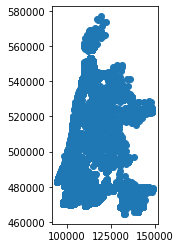

In [22]:
#plot objects
gdf_object.plot()

In [19]:
# Creating a Geographic data frame of the wegvakken
df_n200['geometry'] = df_n200['geometry'].apply(wkt.loads)
#df_n200['geometry'] = wegvakken['geometry'].apply(wkt.loads)
gdf_n200 = gpd.GeoDataFrame(df_n200, crs='epsg:28992', geometry = 'geometry')

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
gdf_object.head()

,ID,attributes.aantalgroepen,attributes.aantaloverspanning,attributes.aantalwindingen,attributes.ad_id,attributes.afstandverharding,attributes.afvalwatertype,attributes.automaatkoppeling,attributes.automaatnummer,attributes.bedrijfsspanning,attributes.beheerder,attributes.beheerobjectsubtyp,attributes.besluitnummer,attributes.besteknummer,attributes.bgtplustype,attributes.bodemhoogte,attributes.boomsituering,attributes.boomsoort,attributes.bordnummer,attributes.bouwjaar,attributes.bovenkantslib,attributes.bprtypebord,attributes.bronhouder,attributes.buis,attributes.cat_waterloop,attributes.codekabel,attributes.conditiescore_opm,attributes.contractnumonderh,attributes.dataleverancier,attributes.datumplaatsing,attributes.deeltrajectnummer,attributes.detectienummer,attributes.diameter,attributes.diametercm,attributes.diametermm,attributes.dieptelegging,attributes.doorrijhoogterijst,attributes.doorrijhoogterijst_1,attributes.doorrijhoogterijst_2,attributes.doorrijhoogterijst_3,attributes.doorrijhoogterijst_4,attributes.doorrijhoogterijst_5,attributes.doorvaarthoogte1,attributes.doorvaarthoogte2,attributes.doorvaarthoogte3,attributes.doorvaarthoogte4,attributes.doorvaarthoogte5,attributes.doorvaarthoogteafg,attributes.eigenaar,attributes.fabrikanttypecode,attributes.faunasoort,attributes.foto,attributes.foto2,attributes.fysiekvoorkomen,attributes.geonauwkeurigheidxy,attributes.gewenstediepte,attributes.gisib_id,attributes.gsmnummer,attributes.halte,attributes.haltenummer,attributes.hectometer,attributes.hoogte,attributes.hoogtebovennap,attributes.huidigestatus,attributes.idcode,attributes.imkl_innetwork,attributes.indicatieveligging,attributes.innetwerk,attributes.kastnummer,attributes.kastovl,attributes.kastvri,attributes.kerendehoogte,attributes.kilometrering,attributes.kp_code,attributes.kwaliteitsniveau,attributes.kwbreedte,attributes.kwhoogte,attributes.kwlengte,attributes.lantaarnnummer,attributes.lengte,attributes.lengtelinkeroever,attributes.lengterechteroever,attributes.lengteuithouder1,attributes.lengteuithouder2,attributes.lichtkarakter,attributes.lichtpuntnummer,attributes.locatie,attributes.mastnummer,attributes.materiaaltype,attributes.montagewijze,attributes.naam,attributes.naar,attributes.ndw_code,attributes.nenbeheerobject,attributes.nominalespanning,attributes.nummer,attributes.nummergekoppeldeau,attributes.objectbegintijd,attributes.objectcode,attributes.objecteindtijd,attributes.objectid,attributes.objectnaam,attributes.oevervak,attributes.omschrijving,attributes.omtrek,attributes.onderhouder,attributes.onderkantslib,attributes.openbaar,attributes.opmerking,attributes.oppervlakte,attributes.paal,attributes.paal2,attributes.paalnummer,attributes.plaats,attributes.postcode_plaats,attributes.priovoorzieningen,attributes.reflectieklasse,attributes.relatievehoogteligging,attributes.rvvtypebord,attributes.serienummer,attributes.simnummer,attributes.snoeifase,attributes.st_area(shape),attributes.st_length(shape),attributes.st_perimeter(shape),attributes.tekst,attributes.telpuntcode,attributes.topcode,attributes.traject,attributes.traject2,attributes.typeplaaginvasiesoort,attributes.typeplaagsoort,attributes.typespec,attributes.vaarwegdeeltraject,attributes.van,attributes.verticale_positie,attributes.verwerkingsstatus,attributes.volgnummer,attributes.waterdiepte,attributes.wegnaam,attributes.wegnr,attributes.wegnummer,attributes.worteldoek_scherm,attributes.xcoordinaat,attributes.ycoordinaat,attributes.zijde,attributes.zijweg,attributes.zitmeubel,attributes.zonnepaneel,geometry.paths,geometry.points,geometry.rings,geometry.x,geometry.y,geometry
0,15,NaN,NaN,NaN,AD.143DA02CAE1846E8B792382959A11018,NaN,NaN,NaN,NaN,NaN,Derden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Philips,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [20]:
#Get centroid from polygon
gdf_n200['centroid'] = gdf_n200['geometry'].centroid

In [21]:
#create column of distance from every road object to road segment
for ID in gdf_object['ID'].unique():
    destinations = []
    for i in gdf_object[gdf_object['ID'] == ID]['geometry']:
        destinations.append(i)
    destinations = MultiPoint(destinations)
    naam = 'Distance' + '_' + str(ID)
    gdf_n200[naam] = gdf_n200['centroid'].distance(destinations)

In [22]:
gdf_n200.head()

,attributes.AD_ID,attributes.NUMMER,attributes.OBJECTBEGINTIJD,attributes.OBJECTEINDTIJD,attributes.OBJECTID,attributes.OMTREK,attributes.OPMERKING,attributes.OPPERVLAKTE,attributes.SHAPE.AREA,attributes.SHAPE.LEN,attributes.TRAJECT,attributes.VERWERKINGSSTATUS,geometry.rings,geometry,centroid,Distance_15,Distance_16,Distance_17,Distance_18,Distance_19,Distance_23,Distance_20,Distance_22,Distance_25,Distance_27_pomp,Distance_27,Distance_27_Zonnepaneel,Distance_28,Distance_29,Distance_30,Distance_31,Distance_36,Distance_35,Distance_32,Distance_38,Distance_40,Distance_39,Distance_46,Distance_64,Distance_76,Distance_77,Distance_81,Distance_86,Distance_87,Distance_97
13,AD.172AAE23A7D1461499700842B98A6B76,61.0,1397174400000,NaN,1618,319.998820,NaN,5999.980307,5999.980307,319.998820,N200a,Actueel,"[[[101188.82189999893, 489956.9490999989], [10...","POLYGON ((101188.8218999989 489956.9490999989,...",POINT (101229.5107999426 489912.4975956234),11.855545,167.715718,1075.673988,4511.769275,187.778536,167.459209,149.490639,24004.906053,16668.986850,1935.973192,16791.815622,39285.695097,154.043740,11.855545,25.479085,14.114125,25.479085,35.520996,613.562876,3667.336639,72.078490,104.330590,5.583102,1092.386548,117.076169,398.925215,194.269594,5620.903924,3617.531610,30128.522193
16,AD.CF53DD3ECE474F46B2B5F71DD300D86F,32.0,1397174400000,NaN,1740,319.999380,NaN,5999.997454,5999.997454,319.999380,N200a,Actueel,"[[[98586.69399999827, 490787.95800000057], [98...","POLYGON ((98586.69399999827 490787.9580000006,...",POINT (98596.92878809125 490730.5822473293),14.317410,845.813740,1648.137428,6945.047942,33.216479,140.239364,723.324917,26317.357981,19126.115204,827.406647,18461.882979,42030.124385,53.729581,10.971648,10.971648,22.938861,111.693591,150.560738,1005.518940,947.868953,8.299592,511.940476,20.838021,1674.099106,8.265011,645.739826,510.652052,8367.867775,883.586327,32882.494071
17,AD.754EEBB1646B4052856190F459B4D47C,1.0,1397174400000,NaN,1765,323.021386,NaN,6071.088630,6071.088630,323.021386,N200a,Actueel,"[[[96902.81060000136, 489098.23530000076], [96...","POLYGON ((96902.81060000136 489098.2353000008,...",POINT (96930.41067329505 489085.49748658),23.204390,234.622913,3494.461065,7978.568192,143.260451,848.465259,2119.257598,26290.648161,19393.543960,2759.576580,20752.961780,42994.248301,61.754536,10.355594,21.712676,34.577707,394.134936,362.561312,123.604521,1760.768430,24.167480,557.087471,2309.953832,2925.920561,13.575954,1696.304547,359.652548,8354.726793,873.977987,33961.439038
37,AD.BE8A6AE04F4148DFB4581C56613C831C,60.0,1397174400000,NaN,3683,320.000075,NaN,5999.998236,5999.998236,320.000075,N200a,Actueel,"[[[101083.58049999923, 489969.58669999987], [1...","POLYGON ((101083.5804999992 489969.5866999999,...",POINT (101132.6118449116 489935.7229785501),13.300259,68.915370,977.844834,4600.007898,285.227007,68.915370,50.719576,24082.948732,16752.811436,1836.351748,16852.543736,39384.005940,54.825456,13.300259,30.884972,16.989534,31.059438,28.070041,528.766854,3567.707565,20.230540,25.853223,6.108641,994.320550,17.463316,299.339484,100.180944,5719.152335,3517.888534,30227.531456
42,AD.959FBB050E7E40AE84EECFDBC161031E,28.0,1397174400000,NaN,3797,319.999094,NaN,5999.973932,5999.973932,319.999094,N200a,Actueel,"[[[98376.65799999982, 491009.9937000014], [983...","POLYGON ((98376.65799999982 491009.9937000014,...",POINT (98396.15546554477 490953.4080593876),6.506703,644.202256,1904.399325,6947.478251,196.391532,439.788371,484.087647,26617.277452,19424.594396,1107.281335,18516.610045,42301.093236,342.001977,39.978019,12.336625,3.993077,39.978019,156.516551,726.698066,786.305818,37.544473,237.649056,38.975865,1928.532131,179.816330,731.594907,235.454906,8636.739464,707.460216,33147.011988


In [23]:
#distance to ecopassage
def distance_ecopassage(geometry):
    return geometry.distance(Point(100240.6, 490365.8))
gdf_n200['Afstand_zeebrug'] = gdf_n200['geometry'].apply(distance_ecopassage)

In [24]:
#Distance to parkinglots
def distance_p1(geometry):
    return geometry.distance(Point(97857.4, 490887.1))

def distance_p2(geometry):
    return geometry.distance(Point(98969.6, 490437.2))

def distance_p3(geometry):
    return geometry.distance(Point(99246.2, 490437.2))

gdf_n200['Afstand_p1'] = gdf_n200['geometry'].apply(distance_p1)
gdf_n200['Afstand_p2'] = gdf_n200['geometry'].apply(distance_p2)
gdf_n200['Afstand_p3'] = gdf_n200['geometry'].apply(distance_p3)

In [25]:
#Distance nearest parking
def distance_nearest_parking(geometry):
    points = {
            'p1' : (97857.4, 490887.1),
            'p2' : (98969.6, 490437.2),
            'p3' : (99246.2, 490437.2),
             'p4': (101498.6, 489986.2)}
    destinations = MultiPoint([points['p1'], points['p2'], points['p3'], points['p4']])
    nearest = nearest_points(geometry, destinations)
    for i in points.keys():
        if nearest[1] == Point(points[i]):
            near = i
    return geometry.distance(Point(points[near]))

In [26]:
#apply nearest parking function
gdf_n200['Distance_Parking'] = gdf_n200['centroid'].apply(distance_nearest_parking)

In [27]:
#find nearest parking
def closest_busstation(geometry):
    points = {  'p0' : (97735.7, 490715.5),
            'p1' : (98183.7, 491026.9),
            'p2' : (98615.9, 491030.1),
            'p3' : (99304.6, 490418.8),
             'p4' : (99705.2, 490279.3)}
    destinations = MultiPoint([points['p0'], points['p1'], points['p2'], points['p3'],  points['p4']])
    nearest = nearest_points(geometry, destinations)
    for i in points.keys():
        if nearest[1] == Point(points[i]):
            near = i
    return geometry.distance(Point(points[near]))

In [28]:
#distance to nearest busstations
def nearest_parking(geometry):
    points = {  'p1' : (97857.4, 490887.1),
            'p2' : (98969.6, 490437.2),
            'p3' : (99246.2, 490437.2)}
    destinations = MultiPoint([points['p1'], points['p2'], points['p3']])
    nearest = nearest_points(geometry, destinations)
    for i in points.keys():
        if nearest[1] == Point(points[i]):
            return i

In [29]:
#apply nearest parking function and nearest bus station function
gdf_n200['Nearest_Parking'] = gdf_n200['centroid'].apply(nearest_parking)
gdf_n200['Distance_Busstation'] = gdf_n200['centroid'].apply(closest_busstation)

In [30]:
#spatial join to get road objects in the segments
zeeweg_object = gpd.sjoin(gdf_object, gdf_n200,  op='intersects')

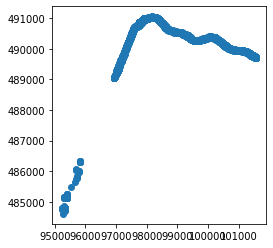

In [31]:
#plot objects on zeeweg
zeeweg_object.plot()

In [32]:
#Only select relevant columns
zeeweg_object = zeeweg_object[['ID', 'attributes.objectbegintijd', 'geometry.y', 'geometry', 'geometry.x', 'attributes.AD_ID']]

In [33]:
#Change column name
zeeweg_object.rename(columns = {'attributes.AD_ID':'WEGVAK'}, inplace = True)
#gdf_objects.rename(columns = {'attributes.AD_ID':'WEGVAK'}, inplace = True)

In [34]:
#get object counts per id
#objects_count = gdf_objects.groupby(["ID", "WEGVAK"]).size().reset_index(name="Count")
objects_count = zeeweg_object.groupby(["ID", "WEGVAK"]).size().reset_index(name="Count")

In [35]:
#spatial join to get road segment of DVCs
dvc_vakken = gpd.sjoin(gdf, gdf_n200, how="inner", op='intersects')

In [36]:
#find closest segment
destinations = {}
for ID in gdf_n200['attributes.AD_ID'].unique():
    destinations[ID] = gdf_n200[gdf_n200['attributes.AD_ID'] == ID]['geometry'][0]
    points = []
polygons = []
for ID in gdf_n200['attributes.AD_ID'].unique():
    polygons.append(gdf_n200[gdf_n200['attributes.AD_ID'] == ID]['geometry'][0])

def closest_segment(geometry):

    min_poly = min(polygons, key=geometry.distance)
    return (list(destinations.keys())[list(destinations.values()).index(min_poly)])

In [37]:
#apply function to find closest segment of DVCs
gdf['closest_segment'] = gdf['geometry'].apply(closest_segment)

In [38]:
#merge DVC dataframe and object dataframe 
dvc_vakken = pd.merge(gdf, gdf_n200, left_on = 'closest_segment', right_on='attributes.AD_ID')

In [39]:
#rename Dataframe
dvc = dvc_vakken

In [40]:
dvc_vakken['Hekken'] = 0

In [41]:
#segments covered by fences
#percentage was retrieved by looking at the pictures provided with markings in the folder 'fences'
fences_percentage = {'AD.14AF41CA9821437EA6627D29F75854FB': 0.5, 'AD.9C32FEC068D54E9F85F54ACFE0C8D177': 0.7,
                    'AD.D6C48F0BB119487AA6120D3A13A1F9ED' : 0.9, 'AD.E15171A44F704ED1874B25495F209A08': 0.9,
                    'AD.08968E332D8C4C25B0C9184054D36924': 0.8, 'AD.0226ABAB6A7B4629B3919A8DC9B8AD9E': 1,
                    'AD.D7D1EDEB970045F8AC51906A91A0F30C': 1, 'AD.959FBB050E7E40AE84EECFDBC161031E': 1,
                    'AD.F45AD87D36064DD2B648F944D20DBB04': 0.5, 'AD.77DBC8B913CB41FE8DF01E3700AA44CB': 0.5,
                    'AD.43D87ACA9FA74E669A4BD07C76D865A4': 0.5, 'AD.CF53DD3ECE474F46B2B5F71DD300D86F': 0.9,
                    'AD.11334A94261142B48D9ADBE97ECBD5E4': 0.5, 'AD.131FCA214F314254A664E30E6C748A01': 0.65,
                    'AD.F7540BC16D424F5989E8A03A6A79CCA1': 0.3, 'AD.F14C801AF15A4C78BC2BEF219F253228': 0.2,
                    'AD.22D70BDC971E47C4A106ECE0C70102': 0.2, 'AD.03BCAE45D9234120B1D00F9DB306878D': 0.1,
                    'AD.FF8DD65EF097400A8DD0D23BA36D8CFA': 0.4, 'AD.895DD2FA39384E4EAE0107092232D163': 0.5,
                    'AD.83A64B368B1C4DEDBC653D08EAD9246C': 0.5}
for i in fences_percentage:
    dvc_vakken.loc[dvc_vakken['attributes.AD_ID'] == i, 'Hekken'] = fences_percentage[i]

In [42]:
#put time to datetime 
def tijd_datetime(tijd):
    return dt.datetime.strptime(tijd, '%Y-%m-%d %H:%M:%S')

In [43]:
#apply tijd_datetime function 
zeeweg_object['Datum'] = pd.to_datetime(zeeweg_object['attributes.objectbegintijd'], infer_datetime_format=True)

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/dateutil/parser/__init__.py:47: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


In [44]:
#apply tijd_datetime function 
#dvc['Datum'] = dvc['Datum'].apply(tijd_datetime)

TypeError: strptime() argument 1 must be str, not Timestamp

In [45]:
#only roads in study area
roads = ['N200a']
boolean_series = gdf_n200['attributes.TRAJECT'].isin(roads)
gdf_n200 = gdf_n200[boolean_series]

In [46]:
#check if collision before ecopassage
before = []
for index, row in dvc.iterrows():
    if row['Datum'] < dt.datetime.strptime('15-09-2017', '%d-%m-%Y'):
        before.append(row['attributes.AD_ID'])

In [47]:
#total collisions per road segment
wegvak_total = {}

for i in dvc['attributes.AD_ID'].unique():
    wegvak_total[i] = len(dvc[dvc['attributes.AD_ID'] == i])

In [48]:
#total ree collisions per road segment
ree_total = {}
for i in dvc['attributes.AD_ID'].unique():
    wegvak = dvc[dvc['attributes.AD_ID'] == i]
    ree_total[i] = len(wegvak[wegvak['Diersoort'] == 'Ree'])

In [49]:
#map dictionaries to df and fill with zero
#calculate DVCs, ree and damhert per segment
dvc_per_wegvak = pd.DataFrame()
dvc_per_wegvak['attributes.AD_ID'] = gdf_n200['attributes.AD_ID']
dvc_per_wegvak['DVC'] = dvc_per_wegvak['attributes.AD_ID'].map(wegvak_total)
dvc_per_wegvak['Ree'] = dvc_per_wegvak['attributes.AD_ID'].map(ree_total)
dvc_per_wegvak['Damhert'] = dvc_per_wegvak['DVC'] - dvc_per_wegvak['Ree']
dvc_per_wegvak['DVC'] = dvc_per_wegvak['DVC'].fillna(0)
dvc_per_wegvak['Ree'] = dvc_per_wegvak['Ree'].fillna(0)
dvc_per_wegvak['Damhert'] = dvc_per_wegvak['Damhert'].fillna(0)
dvc_per_wegvak

,attributes.AD_ID,DVC,Ree,Damhert
13,AD.172AAE23A7D1461499700842B98A6B76,1.0,1.0,0.0
16,AD.CF53DD3ECE474F46B2B5F71DD300D86F,4.0,1.0,3.0
17,AD.754EEBB1646B4052856190F459B4D47C,0.0,0.0,0.0
37,AD.BE8A6AE04F4148DFB4581C56613C831C,3.0,0.0,3.0
42,AD.959FBB050E7E40AE84EECFDBC161031E,4.0,1.0,3.0
43,AD.5BCA10F8C38947ECA1FE34540DDB57D4,0.0,0.0,0.0
44,AD.F7540BC16D424F5989E8A03A6A79CCA1,3.0,1.0,2.0
52,AD.4058513BBCA9480BAE82D8914089D754,0.0,0.0,0.0
53,AD.A1B29DA2A54348C2967990464AB0AB4D,0.0,0.0,0.0
58,AD.782F1CC105B54D939EB48630E928A23A,6.0,2.0,4.0


In [50]:
#count DVC before and after ecopassage
for index, row in dvc_per_wegvak.iterrows():
    if row['attributes.AD_ID'] in before:
        dvc_per_wegvak.loc[index, 'DVC_before'] = float(before.count(row['attributes.AD_ID']))
    else:
        dvc_per_wegvak.loc[index, 'DVC_before'] = 0

In [51]:
#merge DVCs and road segments together
dvc_per_wegvak = pd.merge(dvc, dvc_per_wegvak, left_on = 'attributes.AD_ID', right_on='attributes.AD_ID')

In [52]:
#remove objects before collision
count_total = {}
for index, row in dvc.iterrows():
    wegvak = zeeweg_object[zeeweg_object['WEGVAK'] == row['attributes.AD_ID']]
    count = [0]
    for i in wegvak['Datum']:
        if (i > row['Datum']):
            count[0] += 1
    count_total[row['attributes.AD_ID']] = count, count.append(i)

In [53]:
#remove objects before collision
count_id = {}
for k in count_total:
    if count_total[k][0][0] > 0:
        wegvak = zeeweg_object[(zeeweg_object['WEGVAK'] == k) & (zeeweg_object['Datum'] == count_total[k][0][1])]
        count_id[k] = {}
        for i in wegvak['ID'].unique():
            id_count = {i: len(wegvak[wegvak['ID'] == i])}

            count_id[k].update(id_count)

In [54]:
#rename columns 
dvc_per_wegvak.rename(columns = {'attributes.AD_ID':'WEGVAK'}, inplace = True)
#merge object count and DVC per road segment
model_input = pd.merge(objects_count, dvc_per_wegvak, on='WEGVAK')

In [55]:
#count per object
g = model_input.groupby(['ID'])
f = { 'Count': 'sum'}
g.agg(f)

,Count
ID,
15,1492
16,21
17,17
19,35
20,7
23,40
28,66
29,1648
30,1432


In [56]:
model_input['Objects_after'] = 0

In [57]:
#actual removing of objects before collision
remove_objects = {}
for index, row in model_input.iterrows():
    if row['WEGVAK'] in count_id.keys():
        if row['ID'] in count_id[row['WEGVAK']]:
            model_input['Objects_after'].iloc[index] = count_id[row['WEGVAK']][row['ID']]

/home/dataiku/dss/code-envs/python/Gerda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
#calculate objects over
model_input['object_count'] = model_input['Count'] - model_input['Objects_after']

In [59]:
#change ID to string 
model_input['ID'] = model_input['ID'].astype(str)

In [60]:
#change DVC count to integer
model_input['DVC'] = model_input['DVC'].astype(int)

In [61]:
#Calculate DVCs after ecopassage
model_input['DVC_after'] = model_input['DVC'] - model_input['DVC_before']

In [62]:
#drop duplicates
model_input = model_input.drop_duplicates(subset=['ID', 'Distance_15', 'Distance_16'], keep='first')

In [63]:
#create pivot table of object count per road segment
table = model_input.pivot(index='WEGVAK',columns='ID',values='object_count')
table.head()

ID,15,16,17,19,20,23,27_pomp,28,29,30,31,35,36,39,40,46,64,76,77,81,87
WEGVAK,,,,,,,,,,,,,,,,,,,,,
AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.0,8.0,18.0,1.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN
AD.03B5E0FE9168437FB0353CBB5C0576B6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,15.0,NaN,1.0,NaN,1.0,41.0,NaN,NaN,0.0,NaN,NaN
AD.03BCAE45D9234120B1D00F9DB306878D,4.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,95.0,6.0,7.0,2.0,NaN,5.0,2.0,17.0,NaN,0.0,NaN,NaN,NaN
AD.046CEDD266484D36A82EA354985AB516,12.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,10.0,11.0,16.0,NaN,NaN,NaN,1.0,13.0,NaN,NaN,NaN,NaN,NaN
AD.08968E332D8C4C25B0C9184054D36924,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,17.0,12.0,4.0,4.0,4.0,3.0,NaN,NaN,NaN,NaN,2.0,NaN


In [105]:
#merge object DF and DVC DF
model_input = pd.merge(table, dvc_per_wegvak, on='WEGVAK')


In [106]:
#add distance to model input
gdf_n200.rename(columns = {'attributes.AD_ID':'WEGVAK'}, inplace = True)
model_input = pd.merge(model_input, gdf_n200[['Distance_15', 'Distance_16', 'Distance_17', 'Distance_18', 'Distance_19', 'Distance_23', 'Distance_20', 'Distance_22', 'Distance_25', 'Distance_27_pomp', 'Distance_27', 'Distance_27_Zonnepaneel', 'Distance_28', 'Distance_29', 'Distance_30', 'Distance_31', 'Distance_36', 'Distance_35', 'Distance_32', 'Distance_38', 'Distance_40', 'Distance_39', 'Distance_46', 'Distance_64', 'Distance_76', 'Distance_77', 'Distance_81', 'Distance_86', 'Distance_87', 'Distance_97', 'Afstand_zeebrug', 'Afstand_p1', 'Afstand_p2', 'Afstand_p3', 'Distance_Parking', 'Nearest_Parking', 'Distance_Busstation', 'WEGVAK' ]], on='WEGVAK')

In [107]:
#rename column
dvc_vakken.rename(columns = {'attributes.AD_ID':'WEGVAK'}, inplace = True)

In [108]:
#drop columns
model_input = model_input.drop(columns = ['Datum', 'Aantal', 'Diersoort', 'WildType', 'Geslacht', 'Doodsoorzaak', 'Longitude', 'Latitude', 'X', 'Y',  'Daylight', 'geometry_x', 'attributes.NUMMER', 'attributes.OBJECTBEGINTIJD', 'attributes.OBJECTEINDTIJD', 'attributes.OBJECTID', 'attributes.OMTREK', 'attributes.OPMERKING', 'attributes.OPPERVLAKTE', 'attributes.SHAPE.AREA', 'attributes.SHAPE.LEN', 'attributes.TRAJECT', 'attributes.VERWERKINGSSTATUS'      ])

In [109]:
model_input.head()

,WEGVAK,15,16,17,19,20,23,27_pomp,28,29,30,31,35,36,39,40,46,64,76,77,81,87,Tijd,closest_segment,geometry.rings,geometry_y,centroid,Distance_15_x,Distance_16_x,Distance_17_x,Distance_18_x,Distance_19_x,Distance_23_x,Distance_20_x,Distance_22_x,Distance_25_x,Distance_27_pomp_x,Distance_27_x,Distance_27_Zonnepaneel_x,Distance_28_x,Distance_29_x,Distance_30_x,Distance_31_x,Distance_36_x,Distance_35_x,Distance_32_x,Distance_38_x,Distance_40_x,Distance_39_x,Distance_46_x,Distance_64_x,Distance_76_x,Distance_77_x,Distance_81_x,Distance_86_x,Distance_87_x,Distance_97_x,Afstand_zeebrug_x,Afstand_p1_x,Afstand_p2_x,Afstand_p3_x,Distance_Parking_x,Nearest_Parking_x,Distance_Busstation_x,Hekken,DVC,Ree,Damhert,DVC_before,Distance_15_y,Distance_16_y,Distance_17_y,Distance_18_y,Distance_19_y,Distance_23_y,Distance_20_y,Distance_22_y,Distance_25_y,Distance_27_pomp_y,Distance_27_y,Distance_27_Zonnepaneel_y,Distance_28_y,Distance_29_y,Distance_30_y,Distance_31_y,Distance_36_y,Distance_35_y,Distance_32_y,Distance_38_y,Distance_40_y,Distance_39_y,Distance_46_y,Distance_64_y,Distance_76_y,Distance_77_y,Distance_81_y,Distance_86_y,Distance_87_y,Distance_97_y,Afstand_zeebrug_y,Afstand_p1_y,Afstand_p2_y,Afstand_p3_y,Distance_Parking_y,Nearest_Parking_y,Distance_Busstation_y
0,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.0,8.0,18.0,1.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,00:00:00,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,"[[[98166.79740000144, 491063.3370999992], [981...","POLYGON ((98166.79740000144 491063.3370999992,...",POINT (98220.74397917258 491037.2710109277),4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354,1.0,3.0,1.0,2.0,0.0,4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354
1,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.0,8.0,18.0,1.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,00:00:00,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,"[[[98166.79740000144, 491063.3370999992], [981...","POLYGON ((98166.79740000144 491063.3370999992,...",POINT (98220.74397917258 491037.2710109277),4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354,1.0,3.0,1.0,2.0,0.0,4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354
2,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.0,8.0,18.0,1.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,19:47:00,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,"[[[98166.79740000144, 491063.3370999992], [981...","POLYGON ((98166.79740000144 491063.3370999992,...",POINT (98220.74397917258 491037.2710109277),4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42

In [110]:
#group rows by road segment
model_group = model_input.groupby(model_input['WEGVAK'])

In [111]:
#fill nan with zeros
model_input = model_input.fillna(0)

In [112]:
#correlations
model_input.corr()

,15,16,17,19,20,23,27_pomp,28,29,30,31,35,36,39,40,46,64,76,77,81,87,Distance_15_x,Distance_16_x,Distance_17_x,Distance_18_x,Distance_19_x,Distance_23_x,Distance_20_x,Distance_22_x,Distance_25_x,Distance_27_pomp_x,Distance_27_x,Distance_27_Zonnepaneel_x,Distance_28_x,Distance_29_x,Distance_30_x,Distance_31_x,Distance_36_x,Distance_35_x,Distance_32_x,Distance_38_x,Distance_40_x,Distance_39_x,Distance_46_x,Distance_64_x,Distance_76_x,Distance_77_x,Distance_81_x,Distance_86_x,Distance_87_x,Distance_97_x,Afstand_zeebrug_x,Afstand_p1_x,Afstand_p2_x,Afstand_p3_x,Distance_Parking_x,Distance_Busstation_x,Hekken,DVC,Ree,Damhert,DVC_before,Distance_15_y,Distance_16_y,Distance_17_y,Distance_18_y,Distance_19_y,Distance_23_y,Distance_20_y,Distance_22_y,Distance_25_y,Distance_27_pomp_y,Distance_27_y,Distance_27_Zonnepaneel_y,Distance_28_y,Distance_29_y,Distance_30_y,Distance_31_y,Distance_36_y,Distance_35_y,Distance_32_y,Distance_38_y,Distance_40_y,Distance_39_y,Distance_46_y,Distance_64_y,Distance_76_y,Distance_77_y,Distance_81_y,Distance_86_y,Distance_87_y,Distance_97_y,Afstand_zeebrug_y,Afstand_p1_y,Afstand_p2_y,Afstand_p3_y,Distance_Parking_y,Distance_Busstation_y
15,1.000000,-0.116379,NaN,0.207462,-0.131436,0.093297,-0.170069,0.147692,-0.134263,0.283511,0.616192,-0.070875,-0.042529,-0.171534,-0.084939,-0.518853,NaN,-0.083391,NaN,-0.123585,-0.075822,-0.683907,0.423781,0.201475,0.317513,-0.226443,0.079081,0.380391,0.272081,0.276892,-0.368087,0.328243,0.291535,-0.065725,-0.331600,-0.455561,-0.411730,0.158479,0.056761,0.501193,-0.304655,0.196710,-0.301578,-0.046201,0.205312,0.022030,0.052611,0.345059,0.293006,-0.307801,0.293172,0.211426,-0.301213,-0.446049,-0.396753,-0.480286,-0.326692,0.310635,-0.018284,-0.009176,-0.015480,-0.152262,-0.683907,0.423781,0.201475,0.317513,-0.226443,0.079081,0.380391,0.272081,0.276892,-0.368087,0.328243,0.291535,-0.065725,-0.331600,-0.455561,-0.411730,0.158479,0.056761,0.501193,-0.304655,0.196710,-0.301578,-0.046201,0.205312,0.022030,0.052611,0.345059,0.293006,-0.307801,0.293172,0.211426,-0.301213,-0.446049,-0.396753,-0.480286,-0.326692
16,-0.116379,1.000000,NaN,-0.067306,0.581371,0.610168,-0.027290,0.085526,0.165616,0.411225,-0.028028,0.339974,0.466682,0.144795,0.264374,-0.002937,NaN,0.515725,NaN,0.073415,0.366994,-0.019856,-0.249131,0.104715,-0.072278,0.280728,-0.223151,-0.229662,-0.062761,-0.061499,0.236436,-0.037278,-0.059256,-0.133465,-0.094690,-0.083495,-0.067065,-0.167789,-0.145165,-0.168181,0.058558,-0.096437,-0.164582,0.229281,0.103855,-0.161414,-0.041463,-0.210673,-0.061655,0.058531,-0.058767,0.101445,0.069766,0.210409,0.235131,-0.058009,0.172995,-0.095536,-0.238693,-0.115764,-0.203288,-0.177706,-0.019856,-0.249131,0.104715,-0.072278,0.280728,-0.223151,-0.229662,-0.062761,-0.061499,0.236436,-0.037278,-0.059256,-0.133465,-0.094690,-0.083495,-0.067065,-0.167789,-0.145165,-0.168181,0.058558,-0.096437,-0.164582,0.229281,0.103855,-0.161414,-0.041463,-0.210673,-0.061655,0.058531,-0.058767,0.101445,0.069766,0.210409,0.235131,-0.058009,0.172995
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,0.207462,-0.067306,NaN,1.000000,0.049615,-0.056206,-0.089144,0.017507,0.155627,0.581081,0.114724,0.052577,0.110853,-0.025632,0.350621,-0.263498,NaN,0.054663,NaN,-0.077479,-0.050858,-0.106873,0.003338,0.111160,0.001040,-0.593576,-0.047080,-0.022456,0.009960,0.011277,0.052406,0.033245,0.014996,-0.189745,-0.264047,-0.171791,-0.040514,-0.015377,-0.229761,0.054474,-0.013655,-0.385909,-0.238121,0.059392,0.108195,-0.303200,-0.047789,-0.005245,0.015446,-0.024097,0.015509,0.112452,-0.016752,0.033955,0.037265,-0.160257,-0.015917,0.022480,-0.033108,0.110388,-0.066089,-0.179103,-0.106873,

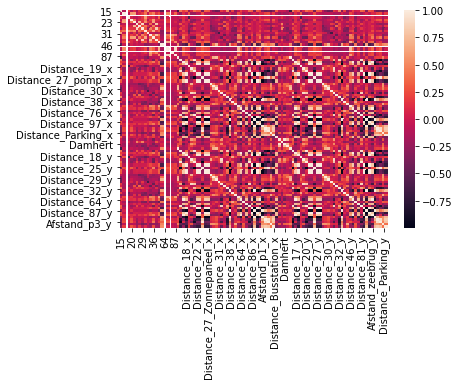

In [76]:
#correlations
sns.heatmap(model_input.corr())

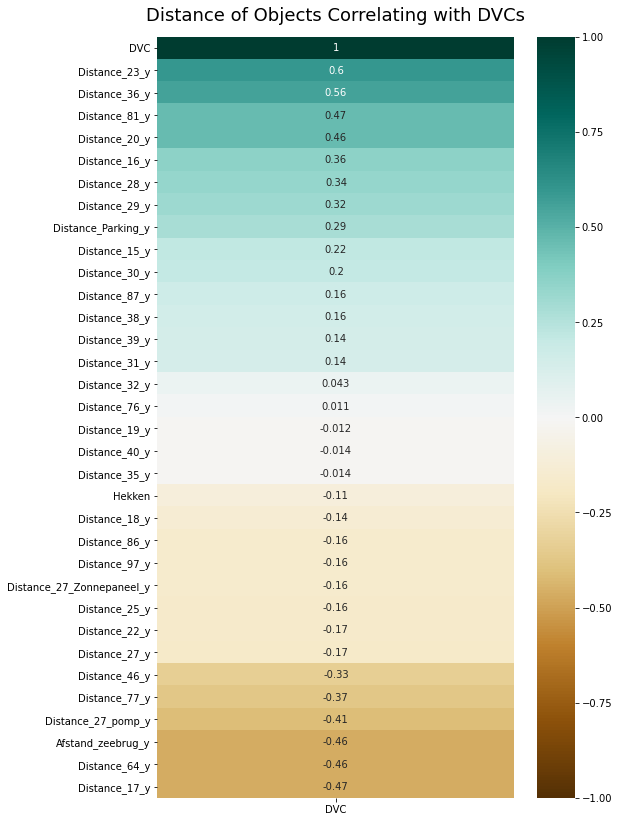

In [77]:
#correlation with dvc
plt.figure(figsize=(8, 14))
heatmap = sns.heatmap(model_input.drop([ 'WEGVAK',  'Tijd', 'closest_segment', 'Distance_15_x', 'Distance_16_x', 'Distance_17_x', 'Distance_18_x', 'Distance_19_x', 'Distance_23_x', 'Distance_20_x', 'Distance_22_x', 'Distance_25_x', 'Distance_27_x', 'Distance_28_x', 'Distance_29_x', 'Distance_30_x', 'Distance_31_x', 'Distance_36_x', 'Distance_35_x', 'Distance_32_x', 'Distance_38_x', 'Distance_40_x', 'Distance_39_x', 'Distance_46_x', 'Distance_64_x', 'Distance_76_x', 'Distance_77_x', 'Distance_81_x', 'Distance_86_x', 'Distance_87_x', 'Distance_97_x', 'Afstand_zeebrug_x', 'Afstand_p1_x', 'Afstand_p2_x', 'Afstand_p3_x', 'Distance_Parking_x', 'Distance_Busstation_x', 'Damhert', 'Ree',  'Afstand_p1_y', 'Afstand_p2_y', 'Afstand_p3_y',  'Distance_Busstation_y', 'DVC_before', '46', '27_pomp', '15', '39', '19', '29', '35', '40', '77', '23', '87', '81', '28', '31', '64', '17', '36', '16', '30', '20', '76', 'Distance_27_Zonnepaneel_x', 'Distance_27_pomp_x'], axis = 1).corr()[['DVC']].sort_values(by='DVC', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Distance of Objects Correlating with DVCs', fontdict={'fontsize':18}, pad=16);

In [78]:
model_input.head()

,WEGVAK,15,16,17,19,20,23,27_pomp,28,29,30,31,35,36,39,40,46,64,76,77,81,87,Tijd,closest_segment,geometry.rings,geometry_y,centroid,Distance_15_x,Distance_16_x,Distance_17_x,Distance_18_x,Distance_19_x,Distance_23_x,Distance_20_x,Distance_22_x,Distance_25_x,Distance_27_pomp_x,Distance_27_x,Distance_27_Zonnepaneel_x,Distance_28_x,Distance_29_x,Distance_30_x,Distance_31_x,Distance_36_x,Distance_35_x,Distance_32_x,Distance_38_x,Distance_40_x,Distance_39_x,Distance_46_x,Distance_64_x,Distance_76_x,Distance_77_x,Distance_81_x,Distance_86_x,Distance_87_x,Distance_97_x,Afstand_zeebrug_x,Afstand_p1_x,Afstand_p2_x,Afstand_p3_x,Distance_Parking_x,Nearest_Parking_x,Distance_Busstation_x,Hekken,DVC,Ree,Damhert,DVC_before,Distance_15_y,Distance_16_y,Distance_17_y,Distance_18_y,Distance_19_y,Distance_23_y,Distance_20_y,Distance_22_y,Distance_25_y,Distance_27_pomp_y,Distance_27_y,Distance_27_Zonnepaneel_y,Distance_28_y,Distance_29_y,Distance_30_y,Distance_31_y,Distance_36_y,Distance_35_y,Distance_32_y,Distance_38_y,Distance_40_y,Distance_39_y,Distance_46_y,Distance_64_y,Distance_76_y,Distance_77_y,Distance_81_y,Distance_86_y,Distance_87_y,Distance_97_y,Afstand_zeebrug_y,Afstand_p1_y,Afstand_p2_y,Afstand_p3_y,Distance_Parking_y,Nearest_Parking_y,Distance_Busstation_y
0,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,8.0,18.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,00:00:00,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,"[[[98166.79740000144, 491063.3370999992], [981...","POLYGON ((98166.79740000144 491063.3370999992,...",POINT (98220.74397917258 491037.2710109277),4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354,1.0,3.0,1.0,2.0,0.0,4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354
1,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,8.0,18.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,00:00:00,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,"[[[98166.79740000144, 491063.3370999992], [981...","POLYGON ((98166.79740000144 491063.3370999992,...",POINT (98220.74397917258 491037.2710109277),4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354,1.0,3.0,1.0,2.0,0.0,4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42495.277823,311.498282,19.852523,19.852523,3.563072,19.897391,15.877061,541.260153,659.812974,31.848847,66.092295,207.105968,2121.604405,15.108629,776.047649,62.937538,8830.825747,574.872769,33340.525452,2077.617692,338.524042,904.875139,1134.133538,393.154142,p1,38.468354
2,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,8.0,18.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19:47:00,AD.0226ABAB6A7B4629B3919A8DC9B8AD9E,"[[[98166.79740000144, 491063.3370999992], [981...","POLYGON ((98166.79740000144 491063.3370999992,...",POINT (98220.74397917258 491037.2710109277),4.469074,496.531677,2097.710336,7029.199436,10.271619,563.088290,317.233346,26796.335911,19610.781724,1301.235801,18624.340068,42

In [113]:
#drop duplicates
model_input.drop_duplicates(keep=False,inplace=True)

In [114]:
len(model_input)

89

In [116]:
# Recipe outputs
final_road_objects = dataiku.Dataset("Objects_dvc")
final_road_objects.write_with_schema(model_input)

89 rows successfully written (b1pwJsf2KD)
